# Use bounding box coordinate data correlated to LiDAR distances to perform a regression on distance

Load the data from May 5, 2018 runs

In [1]:
filename = '/home/robert/PycharmProjects/Stewart/Data/2018-05-05/0015/2018-05-05_0015_columnwise.csv'

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

/home/robert/venv2.7/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
df_raw = pd.read_csv(filename)

In [4]:
df_raw.head()

,frame,object_num,x1,y1,x2,y2,lidar_min,lidarYmin:,lidarYmax:,lidarSegXmin:,lidarSegXmax:
0,3,0,391,251,453,293,17.1,180.0,311.0,151.0,169.0
1,3,1,380,254,405,273,17.1,NaN,NaN,170.0,189.0
2,3,2,343,248,366,265,17.0,NaN,NaN,190.0,208.0
3,3,3,434,255,540,327,92.8,NaN,NaN,209.0,228.0
4,3,4,148,170,157,183,42.8,NaN,NaN,229.0,247.0


In [5]:
number_of_unique_objects = len(df_raw.object_num.unique())
print('we have {} unique objects'.format(number_of_unique_objects))

we have 162 unique objects


In [6]:
df_0 = df_raw.where(df_raw.object_num == 0)

In [7]:
df_8 = df_raw.where(df_raw.object_num == 8)

In [8]:
object_8 = df_8[['frame','x1','y1','x2','y2', 'lidar_min']].dropna()
print('we have {} rows of data for this object'.format(len(object_8)))

we have 2599 rows of data for this object


## Confirm we have object 8

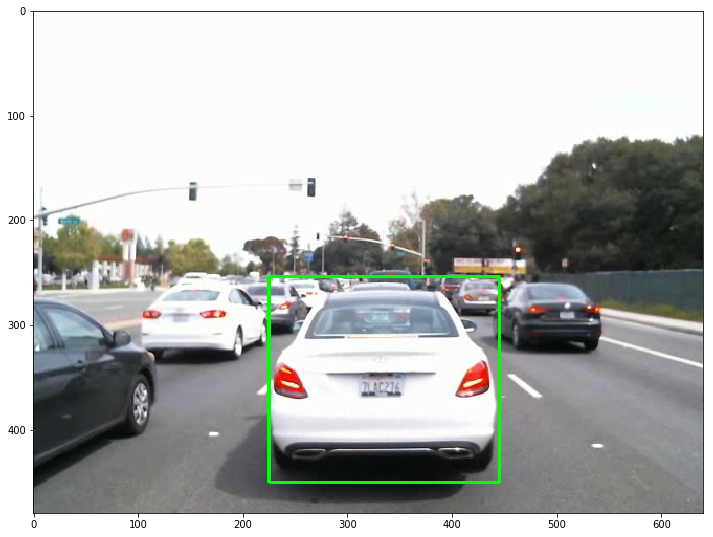

In [9]:
frame_num = 20
row = object_8.where(object_8.frame==frame_num).dropna()
vc = cv2.VideoCapture('/home/robert/PycharmProjects/Stewart/Data/2018-05-05/0015.avi')
vc.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_, img = vc.read()
pt1 = (int(row.x1), int(row.y1))
pt2 = (int(row.x2), int(row.y2))
cv2.rectangle(img, pt1, pt2, (0,255,0), 2)
plt.figure(figsize=(12,16))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## Use object 8 as our dataset.

before we train, let's explore the data

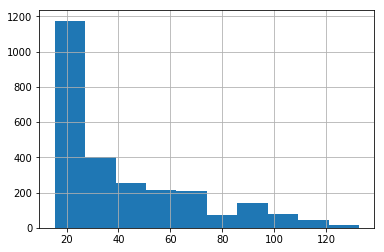

In [10]:
object_8.lidar_min.hist()

We can see for this object, our data is skewed towards "near" distances. It is reasonable to assume our model would be better at predicting closer distances

Let's explore y2 vs min to see if there is a correlation btwn them

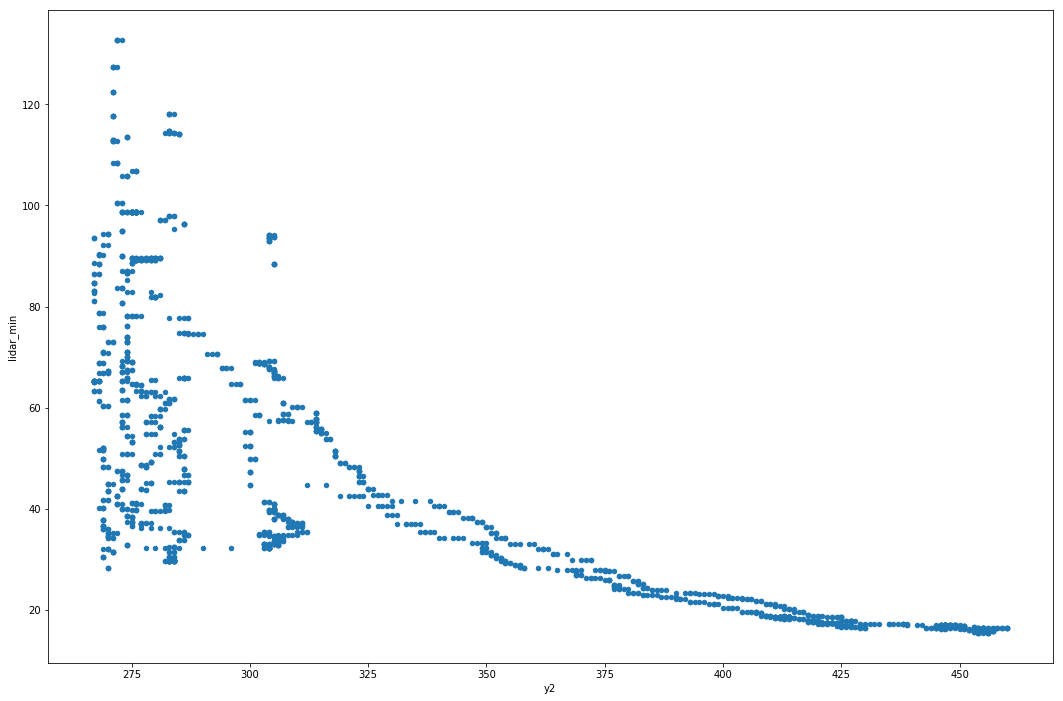

In [11]:
object_8.plot(x='y2', y='lidar_min', figsize=(18,12), kind='scatter')

Looks like we have an inverse regression, let's plot the inverse of distances vs y2

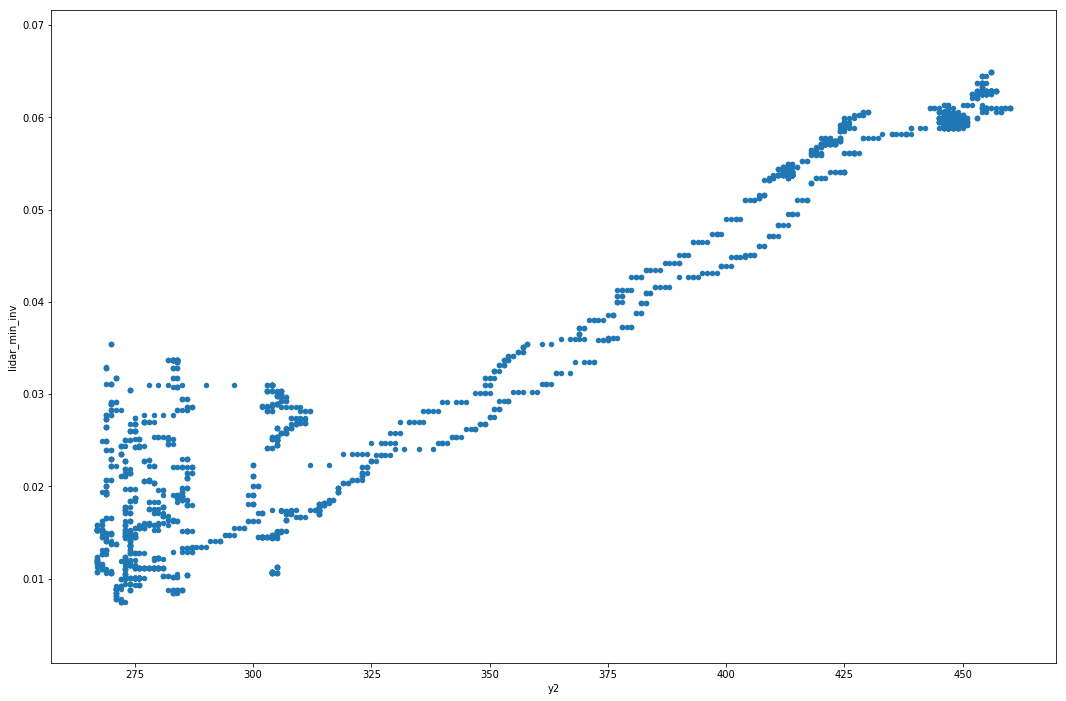

In [12]:
lidar_min_inv = 1/object_8.lidar_min
object_8['lidar_min_inv'] = lidar_min_inv
object_8.plot(x='y2', y='lidar_min_inv', figsize=(18,12), kind='scatter')

## Let's plot the other variables as well 

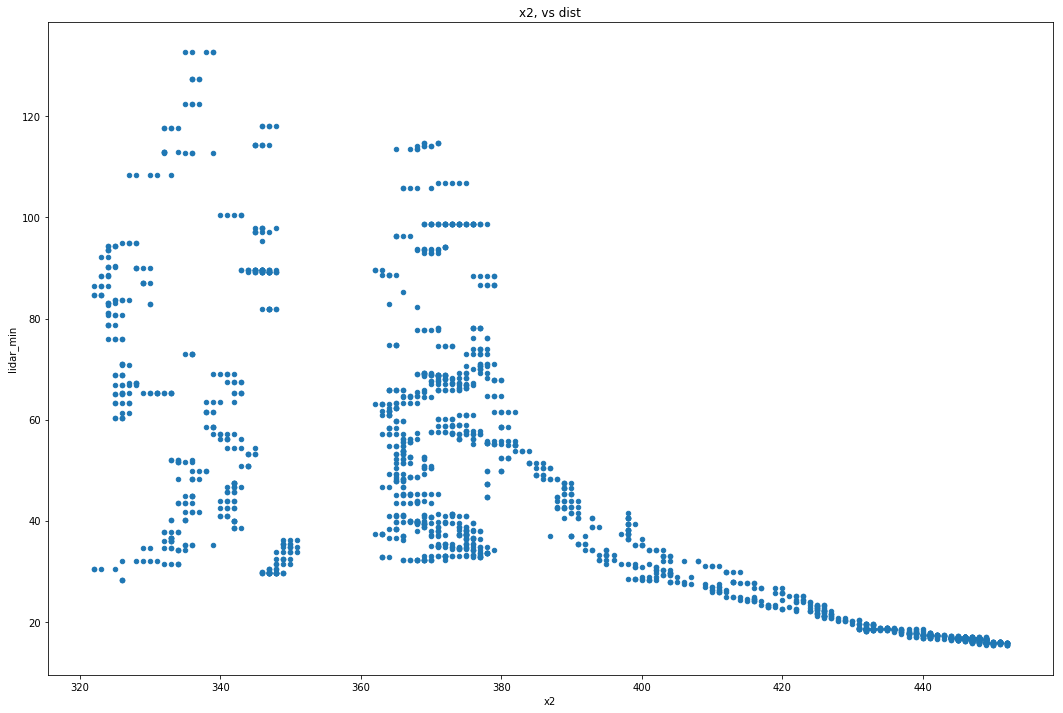

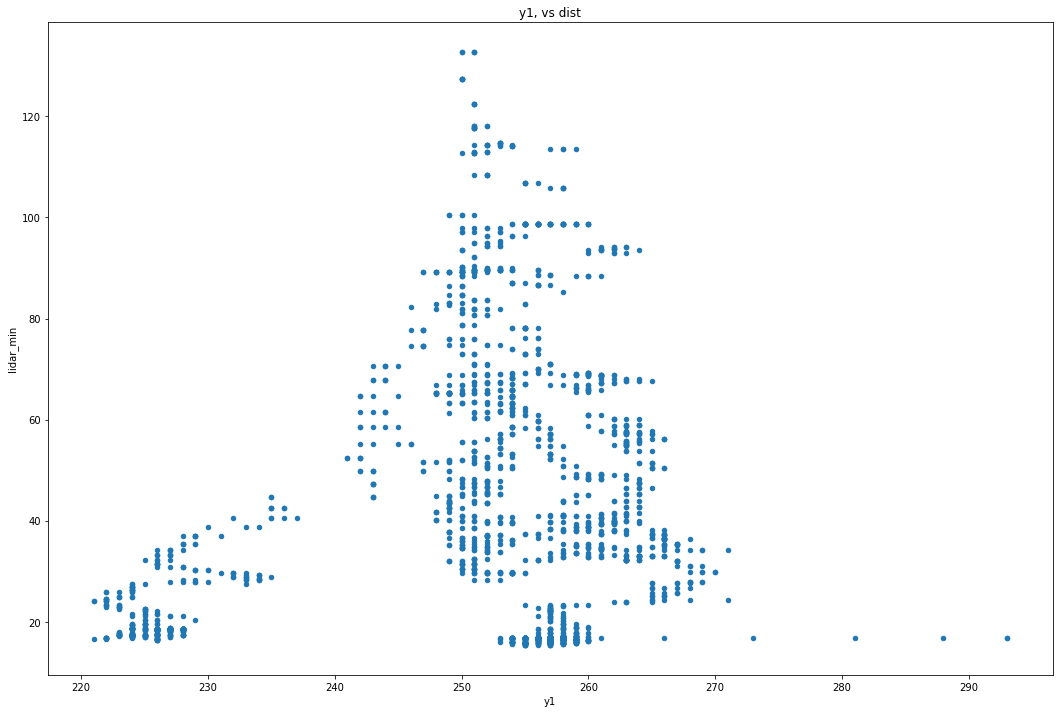

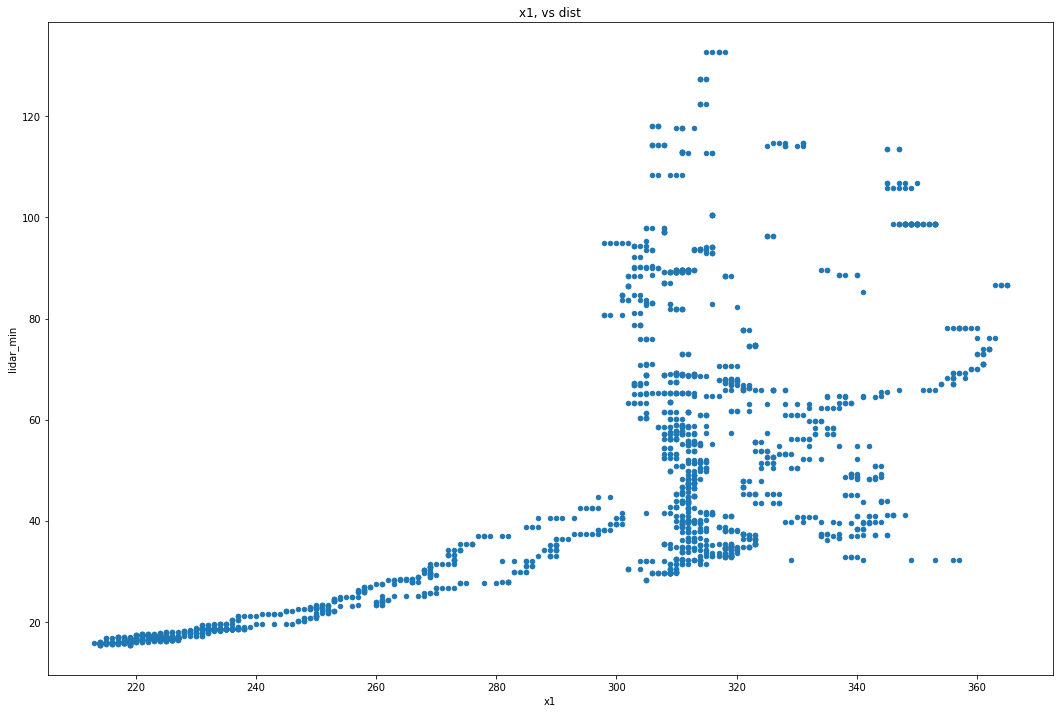

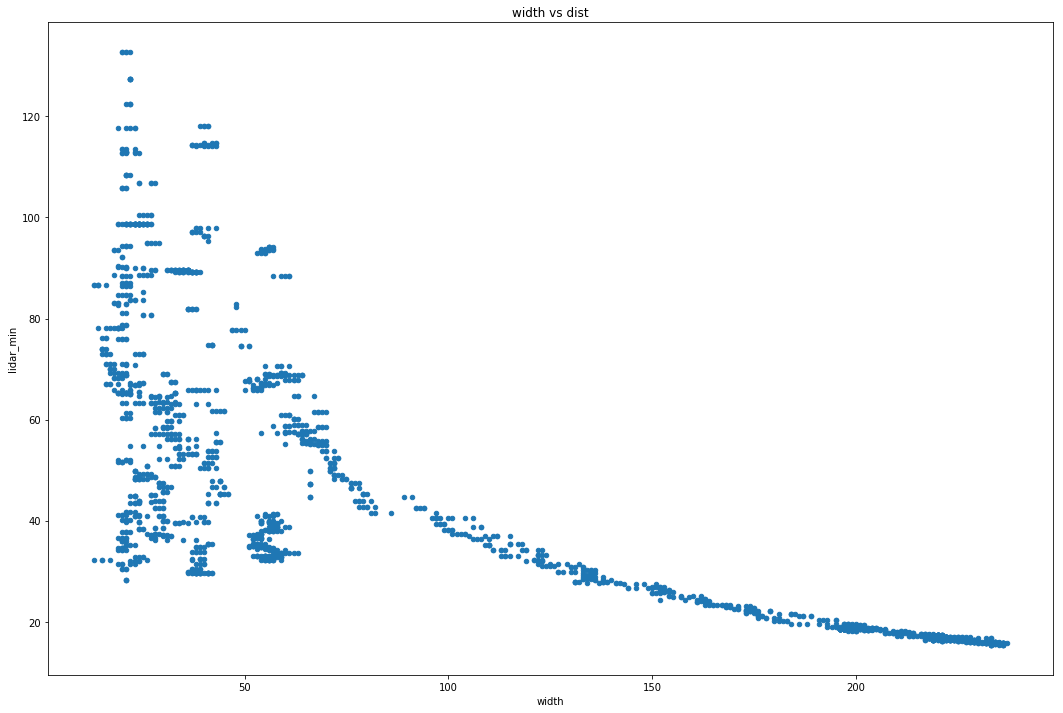

In [13]:
object_8.plot(x='x2', y='lidar_min', figsize=(18,12), kind='scatter', title='x2, vs dist')
object_8.plot(x='y1', y='lidar_min', figsize=(18,12), kind='scatter', title='y1, vs dist')
object_8.plot(x='x1', y='lidar_min', figsize=(18,12), kind='scatter', title='x1, vs dist')
width = object_8.x2 - object_8.x1
object_8['width'] = width
object_8.plot(x='width', y='lidar_min', figsize=(18,12), kind='scatter', title='width vs dist')

Since we're working with Machine Learning / Statistics, it is wise to normalize our data between 0 and 1.0

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
split_ratio = 0.20 # hold out this amount of data for validation
X = object_8[['x1','y1','x2','y2']]
y = pd.DataFrame(object_8['lidar_min'])
def normalize_col(col):
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    # Create an object to transform the data to fit minmax processor
    col_scaled = min_max_scaler.fit_transform(col)
    return col_scaled
for col in X.columns:
    X[col] = normalize_col(X[col].as_matrix().reshape(-1,1))
for col in y.columns:
    y[col] = normalize_col(y[col].as_matrix().reshape(-1,1))

/home/robert/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ae52e890>]],
      dtype=object)

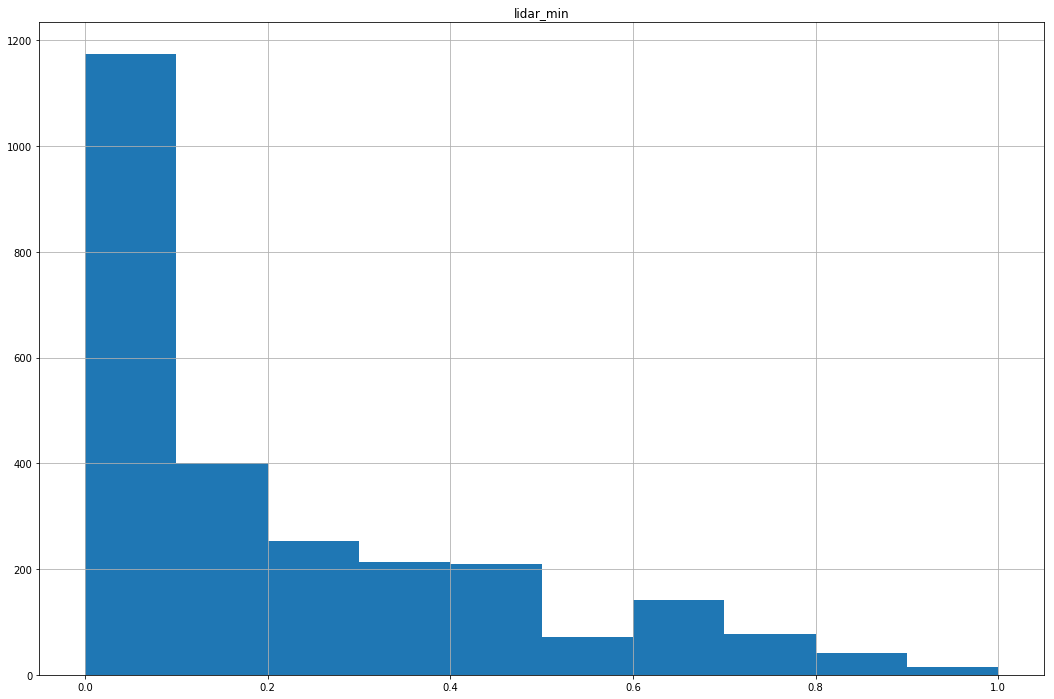

In [79]:
y.hist(figsize=(18,12))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_ratio, random_state=42)
print("We have {} train and {} validation samples".format(len(X_train), len(X_val)))

We have 2079 train and 520 validation samples


In [16]:
X_train.columns

Index([u'x1', u'y1', u'x2', u'y2'], dtype='object')

In [17]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[u'/device:GPU:0']

In [44]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
X_input = pd.DataFrame(X_train)
print(X_input.columns)
model = Sequential()
# () -> () -> ()
model.add(Dense(4, input_dim=len(X_input.columns), activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(x=X_input, y=y_train, epochs=20, verbose=1)

Index([u'x1', u'y1', u'x2', u'y2'], dtype='object')
Epoch 1/20
2079/2079 [==============================] - 0s 224us/step - loss: 0.1155
Epoch 2/20
2079/2079 [==============================] - 0s 79us/step - loss: 0.0802
Epoch 3/20
2079/2079 [==============================] - 0s 78us/step - loss: 0.0656
Epoch 4/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0581
Epoch 5/20
2079/2079 [==============================] - 0s 80us/step - loss: 0.0524
Epoch 6/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0469
Epoch 7/20
2079/2079 [==============================] - 0s 74us/step - loss: 0.0307
Epoch 8/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0206
Epoch 9/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0204
Epoch 10/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0201
Epoch 11/20
2079/2079 [==============================] - 0s 77us/step - loss: 0.0200
Epoch 12/20
2079/2079

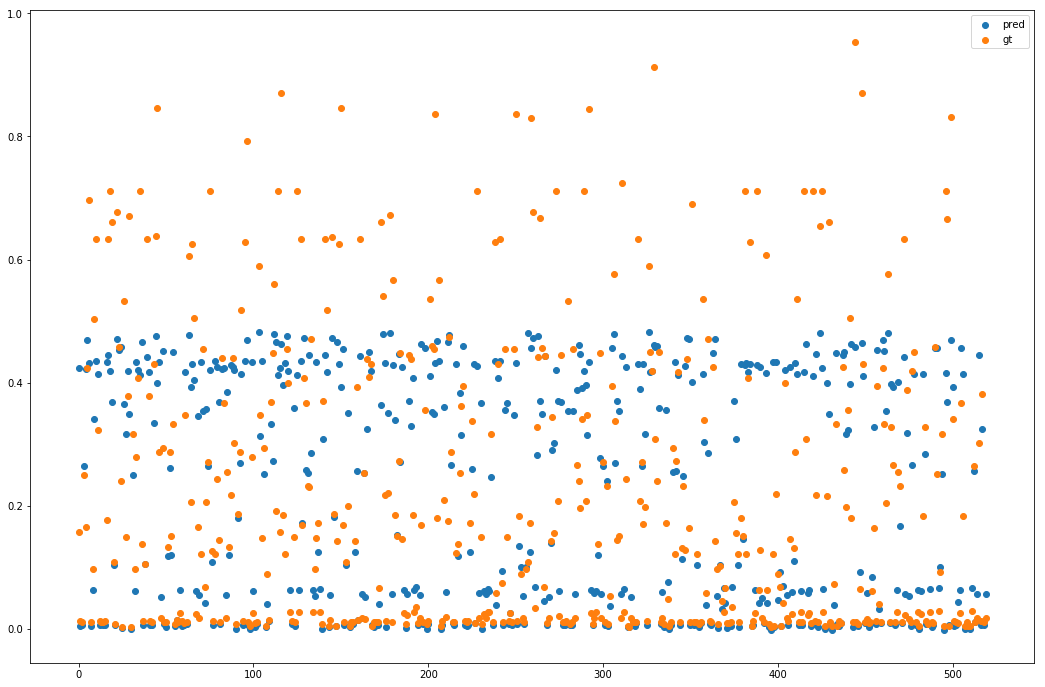

In [67]:
y_pred = model.predict(x=X_val)
results = pd.DataFrame()
results['y_val'] = y_val.lidar_min
results['y_pred'] = y_pred
x_cols = [col for col in X_val.columns]
results[x_cols] = X_val[x_cols]
plt.figure(figsize=(18,12))
plt.scatter(y=y_pred, x=np.arange(0, len(results), 1), label='pred')
plt.scatter(y=y_val, x=np.arange(0, len(results), 1), label='gt')
plt.legend(loc='best')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ae473610>]],
      dtype=object)

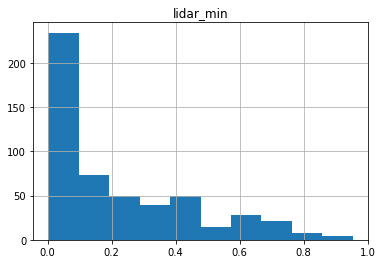

In [80]:
y_val.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8adcd6310>]],
      dtype=object)

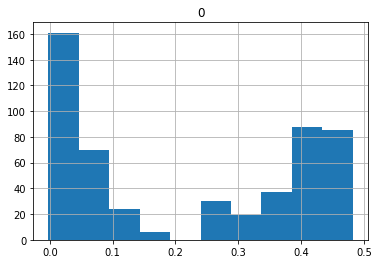

In [82]:
pd.DataFrame(y_pred).hist()

In [77]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(results.y_val, results.y_pred)
results['error'] = mse
mse.min()

0.019780216859445317

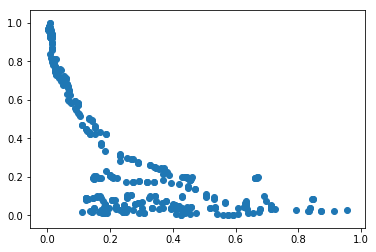

In [51]:
plt.scatter(y_val, X_val.y2)